<a href="https://colab.research.google.com/github/ashwingeeni12/data_science_fundamentals/blob/main/Unit_3/Ashwin_GeenUnit3Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **What is my project?**
**The Big Question**

How Many First Kills will my favorite Pro-Valorant Player Demon1 get?

# Context
What is **Valorant**?

The technical definiton is that Valorant is a 5v5 tactical first person shooter. This essentially means you are in teams of 5 and you need to complete some objective. In Valorant this objective is to get to 13 rounds won. How do you win a round, well it depends wheter you're a defender or an attacker.

At the start of each game you get assigned to be an attack or defender and at round 12 you switch roles. If you are an attacker in order to win a round you need to either kill all the defenders or plant the spike, a bomb, within 2 minutes and let it detonate. The defenders need to kill all the attackers, prevent them from planting the spike within the 2 minutes, or defuse the spike before it detonates.

The stat that we are tracking is first kills. This is pretty self explantatory as it is just the number of times you go the first kill in a round. We are tracking this for a specific pro-player being Demon1 who is my 2nd favorite player. Why is he my 2nd favorite because he openly trash talks all the other players and backs it up, sometimes.

# Install and Import Statements

In [15]:
!pip install "preliz[full,notebook]"

In [16]:
import preliz as pz
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import pymc as pm

# Filtering the Dataset and Histogram

In [17]:
#Reading it in from my github which includes all of his matches from the 2023 season
df = pd.read_csv("https://raw.githubusercontent.com/ashwingeeni12/data_science_fundamentals/refs/heads/main/Unit_3/players_stats.csv")

#Isolating the Player to be Demon1 only and am not including All Match Types as that row in the spreadsheet is his total FK (first kills) ever
df = df.query('Player == "Demon1" and `Match Type` != "All Match Types"')

(array([10., 13.,  7., 10.,  7.,  6.,  1.,  5.,  4.,  2.]),
 array([ 0. ,  1.6,  3.2,  4.8,  6.4,  8. ,  9.6, 11.2, 12.8, 14.4, 16. ]),
 <BarContainer object of 10 artists>)

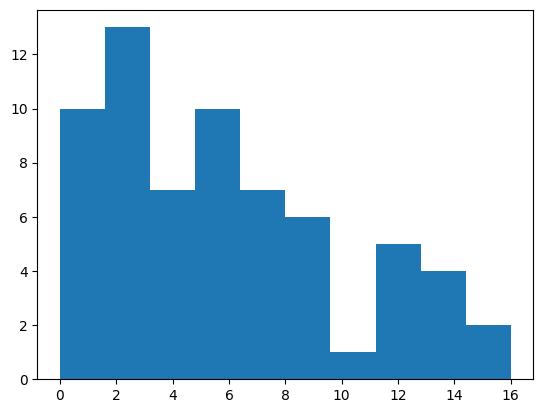

In [18]:
#setting new variable firstKills equal to only the column we need
firstKills = df[['First Kills']]

#plotting the histogram of the firstKills
plt.hist(firstKills)

# Statistics

In [19]:
firstKills.std()

,0
First Kills,4.173981


In [20]:
firstKills.mean()

,0
First Kills,5.876923


In [21]:
firstKills.skew()

,0
First Kills,0.605611


In [22]:
firstKills.var()

,0
First Kills,17.422115


In [23]:
firstKills.kurtosis()

,0
First Kills,-0.574138


In [24]:
len(firstKills)

65

# 1st Attempt

The first distribution I tried to use was the **Poisson Distribution**. I initialy choose this distribution because my data is a discrete data set, as you can't have half a kill, and because the description of it said that it is "often used to model the number of events occurring in a fixed period of time when the times at which events occur are independent" which made sense for my dataset.

**My Prior**

The Poisson Distribution only takes in one parameter, mu, which represents the "**expected number of occurrences during the given interval**" or the mean. So for my prior I needed a distribution that would model what I think the expected number of kills was.  

Because I have watched the game a lot I had a range of numbers that I believe the expected number of kills was. This range was **3.25 to 6**. How did I get these numbers? Well, as explained before the number of rounds you need to win in a game is 13, the minimum rounds played, but then the maximum would be 24 if one team won 13 and the other 11. This is because the game follows a match point system similar to volleyball or tennis where you have to win by 2 rounds. This means the game could go into overtime but that is pretty rare, I have never seen it in my viewing history, so lets assume the maximum rounds played is 24.

From my knowledge the most aggresive player, like Demon1, will see a person first about half of the time. So Demon1 would see a player 6.5-12 rounds. Now Demon1 is a decent 1v1'er so I believe he will win 50% of these fights, meaning he will get the kill 50% of the time. This brings the total first kills from 3.25-6.

I think each of those values inbetween 3.25 and 6 are equally likely so to model that we will be using a uniform distirbution.

This prior will be used multiple times throughout the different distributions.




<Axes: >

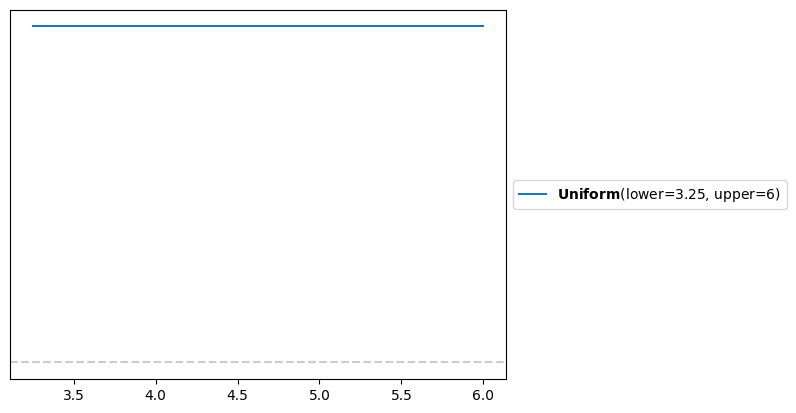

In [25]:
#Prior for the Poisson Model with 3.25 being the amount of FK's in 13 rounds and 6 for 24 rounds
prior = pz.Uniform(lower = 3.25, upper = 6.)

prior.plot_pdf()

Output()

Output()

<Axes: title={'center': 'μ'}>

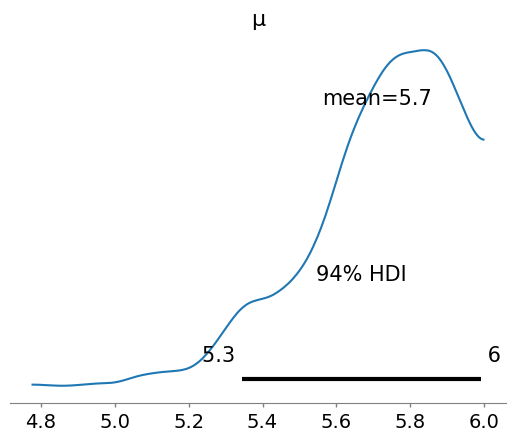

In [26]:
#Creating the Poisson model using 3-6 in a uniform as my prior representing the mu value
with pm.Model() as model_valPoisson:

    μ = pm.Uniform('μ', lower = 3.25, upper = 6.)

    Y = pm.Poisson('Y', mu = μ, observed = firstKills)

    data = pm.sample()

az.plot_posterior(data)

In [27]:
pm.sample_posterior_predictive(data, model=model_valPoisson, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

(0.0, 20.0)

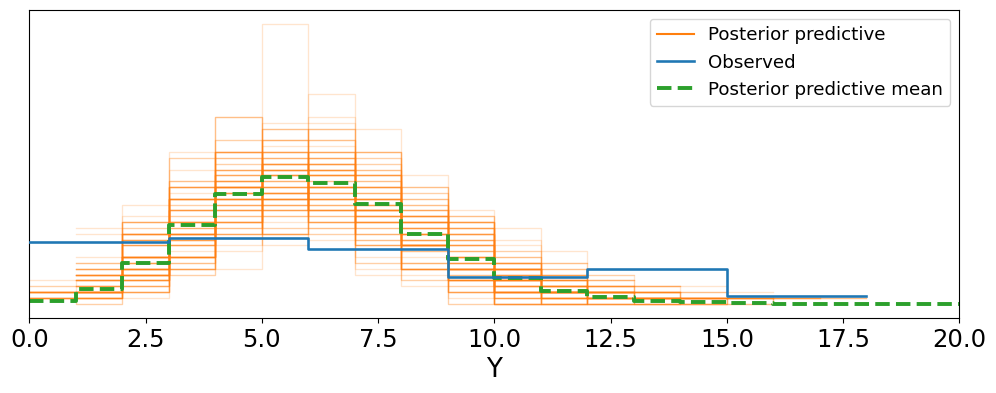

In [28]:
ppc = az.plot_ppc(data, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C2"])

#Just for readability purposes
ppc.set_xlim(0, 20)

**Why The Hell Does It Look Like That**

Well it looks like this because Poisson is a discrete distribution. This means the output displayed would be seen in terms of integer values creating a chart that looks brick like. Now my data is discrete so does this mean I have to continue using discrete distributions, no! You can use a continous distribution for a discrete dataset when your data is relatively closely clustered or just looks like a curve from a continuous distribution. So I decided to try my luck at a the continuous side of things.

# Gamma and Weibull, 2 sides of the same coin

After scrolling through the different distributions for a little while I realied the **Gamma Distribution** looked somewhat similar to how my histogram looked. So I wanted to use it. However my data includes values of 0 as getting 0 kills is possible. The next step was finding a distibution similar to Gamma that includes 0 in its support. The choice being **Weibull Distribution**. Its support includes 0 and it is similar to the Gamma Distribution.



**My Priors**

The Weibull Distribution takes in 2 parameter being alpha, the shape parameter. This is saying that this alpha value controls the shape of the probability distribution or how the distribution behaves over time. A large alpha value means an increasing rate over time and a small one means decreasing. Because our data is skewed to the right we will use an alpha value greater than 1 but not too large because our data is realtively close togeter. So somewhere between 1 and 2 should be our most likely value with the possiblity of going to 3. The first distribution that come to mind to model this was the **Gamma Distribution** so in order for it to show what I described earlier I tested alpha and beta values to get to here.

<Axes: >

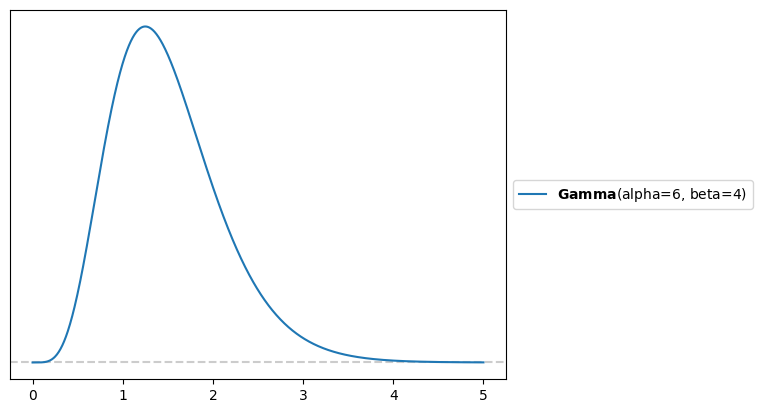

In [29]:
#Plotting a Gamma based on a description I explained above.
#Tested alpha and beta values by comparing to the example ones giving and trialed and errored until it looks satisfactory
prior = pz.Gamma(alpha = 6., beta = 4.)

prior.plot_pdf(support = (0, 5))

**My Priors**

The other parameter in the Weibull distribution is the beta value. This is know as the scale parameter. It basically controls the spread of the data, so a lower beta value means the data is more togeter while a large means it is more spread out. For this prior, I don't know much about the spread but I have some idea of what it could be. Since our previous prior (for Poisson) use a Uniform prior with a lower of 3 and 6, we can see the difference between these 2 values is 3. This represents our range and in order to represent the spread we can just apply that range to our previous values creating a Uniform with a lower of 3-3=0 and an upper of 6+3=9.

<Axes: >

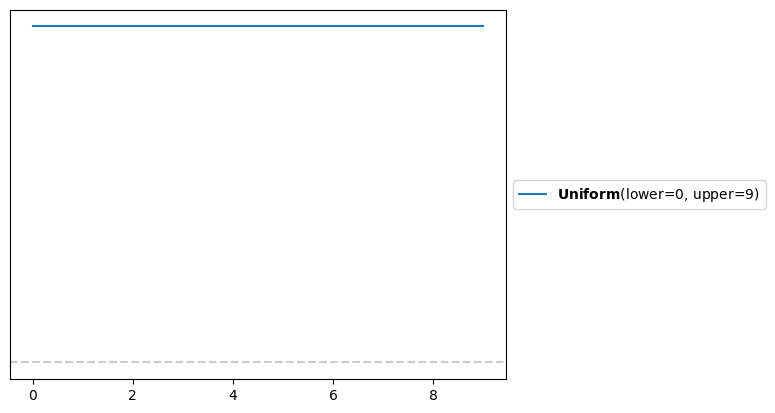

In [30]:
'''
Creating a new unifrom prior based upon the Poisson's prior of Uniform(3,6) by using the range of 6-3=3,
and creating a new spread by substracting that range from the lower and adding it to the upper
'''
prior = pz.Uniform(lower = 3. - 3., upper = 6. + 3.)

prior.plot_pdf()

In [31]:
with pm.Model() as model_valWeibull:
    #Here we are using the Gamma prior that we got before for the shape parameter
    α = pm.Gamma('α', alpha = 6., beta = 4.)

    #Here is the uniform prior for beta, the scale parameter
    β = pm.Uniform('β', lower = 0., upper = 9.)

    #creating the posterior for Weibull using the first kills data
    Y = pm.Weibull('Y', alpha = α, beta = β, observed = firstKills)

    data = pm.sample()

az.plot_posterior(data)

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'α_log__': array(0.89548326), 'β_interval__': array(-0.6668654)}

Logp initial evaluation results:
{'α': -0.89, 'β': -1.5, 'Y': -inf}
You can call `model.debug()` for more details.

**Soooo What Happened**

Well I am going to be honest. I don't know. It says my starting values of Gamma and Uniform have values that are negative but they literally don't. So why is it giving me an error, I HAVE NO FREAKING CLUE. The only other problem I could identify is that my dataset could have negative values but it doesn't. After further research online I noticed that lots of other people had this same error when using data sets that nave the numbers 0. Just for testing purposes I replaced all the 0's with really small numbers.

In [32]:
#Replacing 0's with reallllly small numbers
newFirstKills = firstKills.replace(0, 0.00000000000000000000000001)

Output()

Output()

array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>],
      dtype=object)

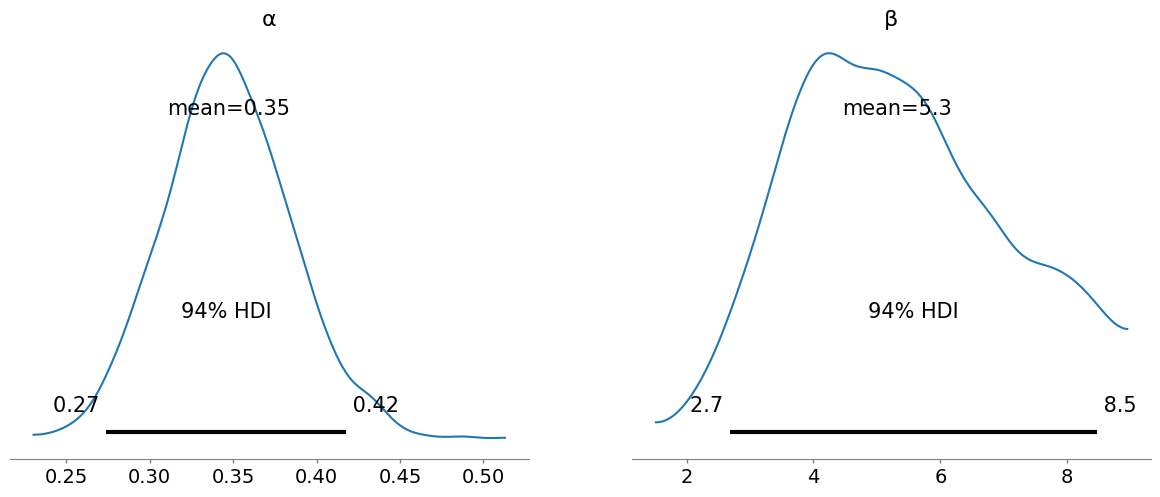

In [33]:
with pm.Model() as model_valWeibullN:
    #Here we are using the Gamma prior that we got before for the shape parameter
    α = pm.Gamma('α', alpha = 6., beta = 4.)

    #Here is the uniform prior for beta, the scale parameter
    β = pm.Uniform('β', lower = 0., upper = 9.)

    #creating the posterior for Weibull using the new first kills data after changing the 0 values
    Y = pm.Weibull('Y', alpha = α, beta = β, observed = newFirstKills)

    data = pm.sample()

az.plot_posterior(data)

In [34]:
pm.sample_posterior_predictive(data, model=model_valWeibullN, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

(0.0, 20.0)

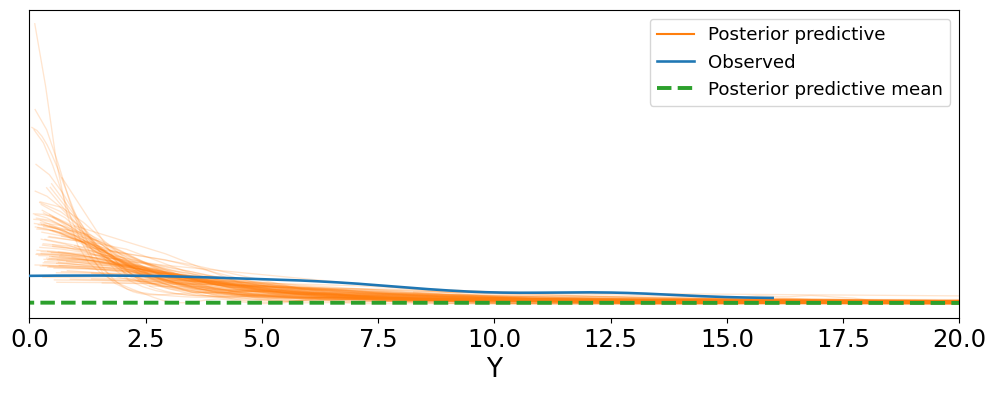

In [35]:
ppc = az.plot_ppc(data, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C2"])
ppc.set_xlim(0, 20)

**Well that looks different**

So this model obiously doesn't represent my data well so lets continue looking for more models. But before we move on the next model, I want to try Gamma this time. Because we replaced all the 0's with really small numbers Gamma should work. Gamma also has alpha and beta values that represent shape and scale so we don't need to change our priors.

Output()

Output()

array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>],
      dtype=object)

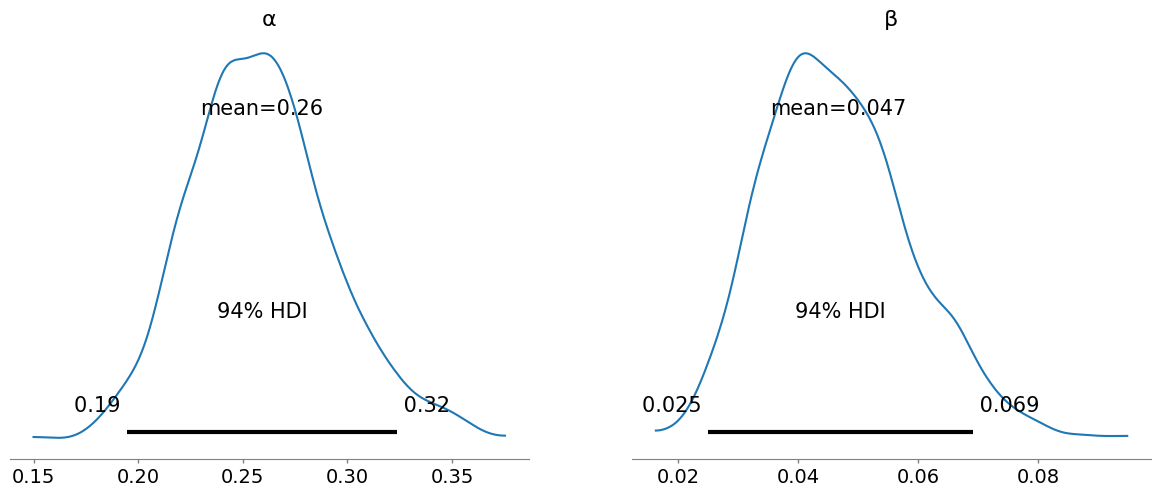

In [36]:
with pm.Model() as model_valGammaN:
    #Here we are using the Gamma prior that we got before for the shape parameter
    α = pm.Gamma('α', alpha = 6., beta = 4.)

    #Here is the uniform prior for beta, the scale parameter
    β = pm.Uniform('β', lower = 0., upper = 9.)

    #creating the posterior for Weibull using the new first kills data after changing the 0 values
    Y = pm.Gamma('Y', alpha = α, beta = β, observed = newFirstKills)

    data = pm.sample()

az.plot_posterior(data)

In [37]:
pm.sample_posterior_predictive(data, model=model_valGammaN, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

(0.0, 20.0)

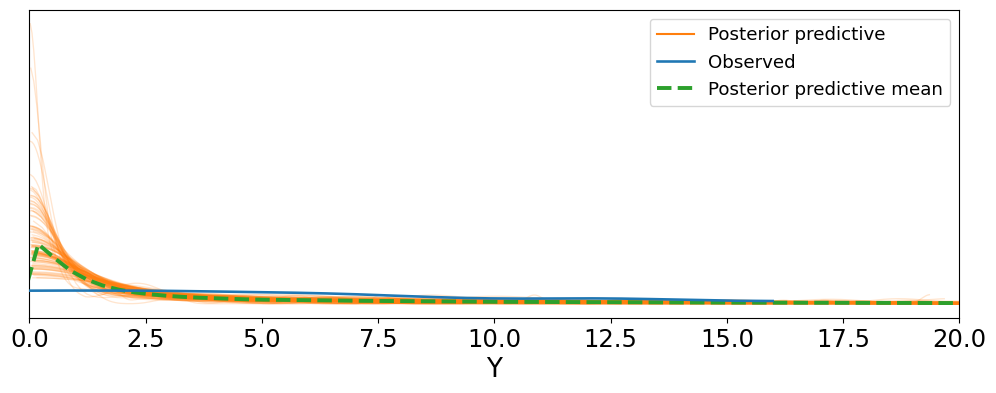

In [38]:
ppc = az.plot_ppc(data, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C2"])
ppc.set_xlim(0, 20)

**So the Gamma looks a lot like the Weibull**

So looks like its time to find a new model. Rather than utilizing an alpha and beta prior I wanted to explore and mu  and sigma side of things.

# Moyal

So at this point I still wanted to use a distribution similar to Gamma and Weibull but that would work with actual 0 values. The Moyal distribution looks similar to the Gamma and Weibull distribution but has support for negative numbers which might fix the error I have. It takes in mu and sigma for parameters.

**My Priors**

For the mu prior, I will set it to my previous uniform of Uniform(lower = 3, upper = 6) as I used that before to represent the mean. Then my sigma value represents the scale parameter. Sigma also respresents the standard deviation which is related to the spread. I am just going to assume the standard deviation will be around 4 because a lot of the values are centered togeter, but there a few outliers that cause it to increase. I think the sigma value will most likely be at 4ish but has a possibility to represent higher and lower values. After looking at the distributions I found the Logistic to model what I am trying to say pretty well. After testing different values I landed on the LogLogistic model have an alpha of 4.5 and a beta of 5.  

<Axes: >

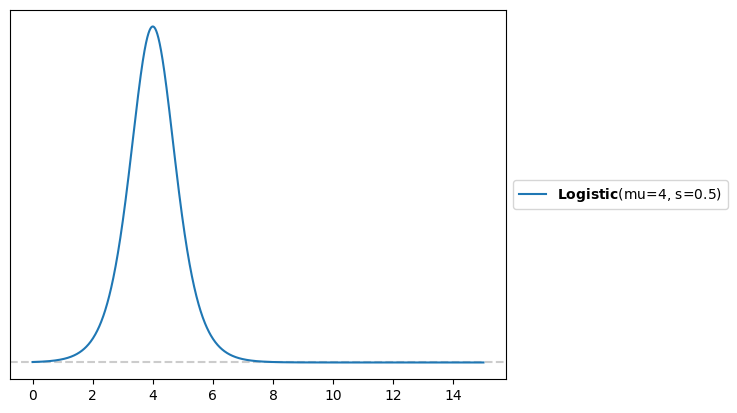

In [39]:
prior = pz.Logistic(mu = 4, s = .5)

prior.plot_pdf(support=(0,15))

Output()

Output()

array([<Axes: >, <Axes: title={'center': 'μ'}>], dtype=object)

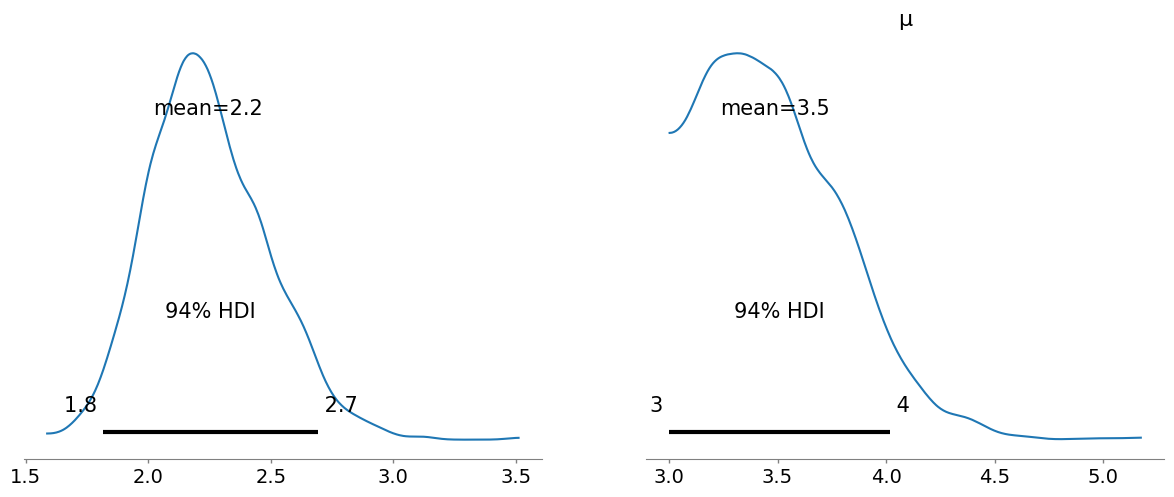

In [41]:
with pm.Model() as model_valMoyal:

    #this is my mu parameter which is the mean/shape parameter
    μ = pm.Uniform('μ', lower = 3., upper = 6.)

    #This is my sigma prior which represents the scale parameter or stdev
    σ = pm.Logistic('', mu = 4., s = .5)

    Y = pm.Moyal('Y', mu = μ, sigma = σ, observed = firstKills)

    data = pm.sample()

az.plot_posterior(data)

In [42]:
pm.sample_posterior_predictive(data, model=model_valMoyal, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

(0.0, 20.0)

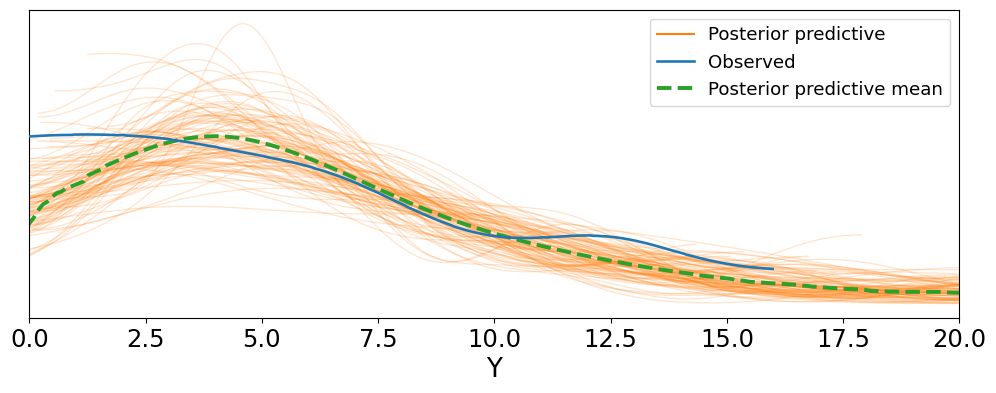

In [43]:
ppc = az.plot_ppc(data, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C2"])
ppc.set_xlim(0, 20)

**Mid as hell**

So this isn't that good, but it is the best we have so far. However, after looking at my observed I thought it looked sneakily similar to a different distribution.

# The Final Distribution, HalfStudentT

After testing these different models and looking at the observed I realized it looks really similar to HalfStudentT distribution. The HalfStudentT distribution contains 2 parameters being nu and sigma.

**My Prior**
The nu values represents the normality parameter which tells me about the possibility of extreme values. A smaller nu tell me that there is more extreme values while higher says less. My variance is 17 because of this I am just going to guess that the nu value will lie somewhere from 3-7 because 17 is a moderate level of variance so I am creating a range of which I think nu would occur. Because I have a range where I think any number in between could occur, I will just use a uniform again.

<Axes: >

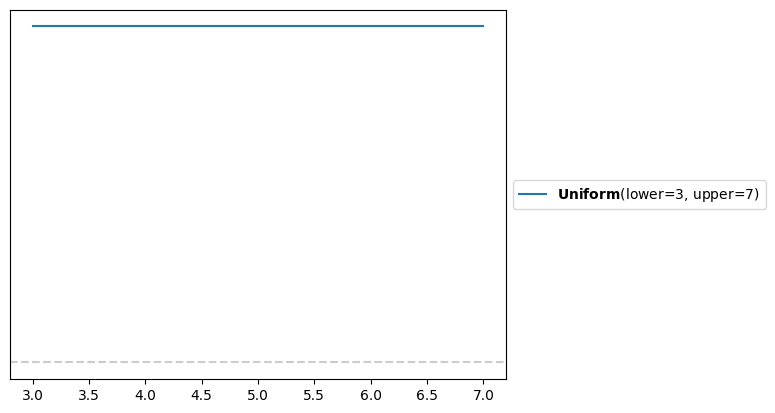

In [44]:
#This prior represents the nu in HalfStudentT with 3 being a low and 5 being a high
prior = pz.Uniform(lower = 3., upper = 7.)

prior.plot_pdf()

**My Prior**

The other parameter is the sigma parameter which represents the scale parameter. Because in Moyal I used a prior to represent a similar parameter I'll just use the same prior.

Output()

Output()

array([<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'σ'}>],
      dtype=object)

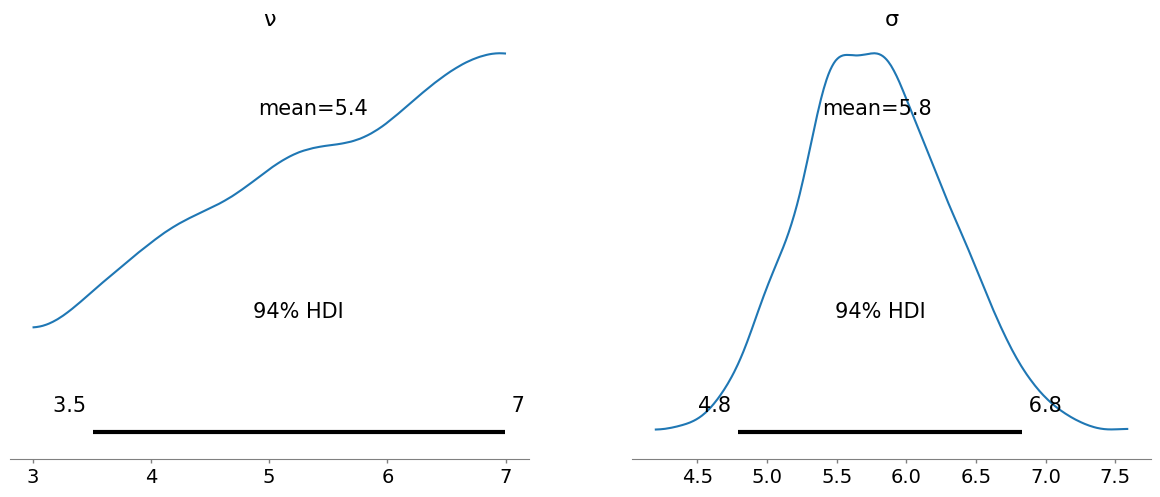

In [45]:
with pm.Model() as model_valHalfStudentT:

    #this is my nu parameter which is the normality parameter
    ν = pm.Uniform('ν', lower = 3., upper = 7.)

    #This is my sigma prior which represents the scale parameter or stdev
    #PYMC doesn't have the LogLogistic model but Logistic is just the same thing
    σ = pm.Logistic('σ', mu = 4., s = .5)

    Y = pm.HalfStudentT('Y', nu = ν, sigma = σ, observed = firstKills)

    data = pm.sample()

az.plot_posterior(data)

In [46]:
pm.sample_posterior_predictive(data, model=model_valHalfStudentT, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

(0.0, 24.0)

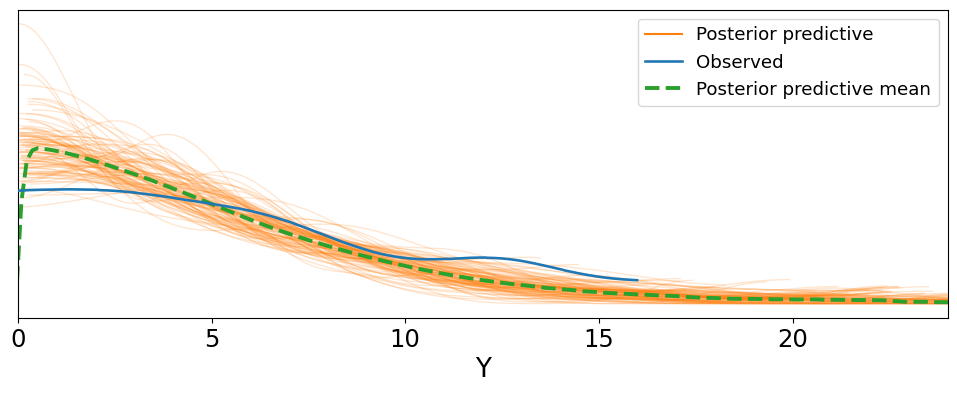

In [47]:
ppc = az.plot_ppc(data, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C2"])
ppc.set_xlim(0, 24)

# Final Analysis

So my final likelihood using a HalfStudentT fits my data pretty well. But why? Lets analyze the mean, variability, skewness, and kurtosis to see how they line up.

**Mean**: The observed data shows more variability and fluctuation. Since the observed line shows several peaks and dips, its mean would be more influenced by these fluctuations. As the observed line is higher than the posterior mean in some regions, this suggests that the mean of the observed data might be slightly higher than the posterior predictive mean in those ranges. The posterior predictive mean is smoother and captures the general slope of the data. The mean of the posterior predictive distribution is likely lower than the observed mean in areas where the blue line fluctuates upward, but it remains consistent across the entire range of Y-values. Because of the underestimate in those areas eg. 5-15 but is higher from 0-5 this probably averages out the mean makeing them pretty close to each other.

**Variability**: The posterior predictive mean shows less variability and is more stable, reflecting an averaged prediction from the posterior distribution.
The observed data, while relatively following the same trend, displays more variability with some curves and peaks, indicating that the actual data has fluctuations that the model predictions smooth over. The variability for the observed changes is noticible between 7.5 and 15.

**Skewness**: The observed data seems to have a slightly asymmetric pattern, especially between kill count of 5 to 15. While it generally follows a decreasing trend, their are fluctuations around this range. This could suggest positive skewness in the observed data because the observed line decreases gradually, with some peaks suggesting occasional higher-than-expected values. However, these deviations do not appear overly extreme. The posterior predictive mean is much smoother and displays less variation, maintaining a relatively symmetric downward trend.  It tends to smooth out the fluctuations,this leads to a more balanced, symmetric shape compared to the more variable and potentially skewed observed data.

**Kurtosis**: The observed data has some noticeable peaks and dips, especially between Y-values of 5 and 15. These fluctuations indicate a higher kurtosis. This could imply that the observed data has more outliers or unusual events compared to what the model predicts, even if they aren't extreme outliers.
The posterior predictive mean is much smoother, with fewer deviations from a consistent downward trend. This suggests lower kurtosis because the distribution is more spread out and doesn't exhibit sharp peaks or heavy tails.
The posterior predictive mean shows a smoother pattern that averages out extremes present in the observed data. It reflects the problem of all model that they fit an overall trend without accounting for highly peaked or rare events.

# Conclusion

**Will my model be accurate forever?**

Probably not, Demon1 is a rookie who just entered the scene. He has a lot more potential in his gameplay so he will probably do better. If by some case he gets bought by  a really bad team or has a role change so he no longer takes fights first then it won't be accurate.

If by some miracle the entirety of the this season gets repeated where everyone else had the same team, tactics, and skill level. The model wouldn't be as accurate even then, This is because while Valorant is a game of skill, there still is an aspect of luck. Do I think the HalfStudentT overall is a good model to predict this. Yes I think this is a pretty good model. Most people won't get these high numbers, above 5, pretty often so having a model where those values are the most probable makes sense.

**Now will this distribution work for every player?**

No definitely not, every player has a unique role and skill level. Some players are more consistent where an inverse gamma would make more sense, or they just are even a uniform would make more sense.

In essence, based on the different distributions avalible and how my data set works I think the **HalfStudentT** distribution is the best one.